# Aujourd'hui on se fait rouler par les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html


Ici, c'est le notebook dédié uniquement à:
1. Gestion des données manquantes
2. Correction des erreurs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

#misc libraries
import time
import random as rnd
import os, gc

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.6.4 |Anaconda custom (64-bit)| (default, Mar 12 2018, 20:20:50) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
matplotlib version: 2.2.2
NumPy version: 1.12.1
SciPy version: 1.0.0
IPython version: 6.2.1
scikit-learn version: 0.19.1
seaborn version: 0.8.1
-------------------------


Moi j'ai ça:

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]

pandas version: 0.22.0

matplotlib version: 2.1.2

NumPy version: 1.12.1

SciPy version: 1.0.0

IPython version: 6.2.1

scikit-learn version: 0.19.1

seaborn version: 0.8.1


In [2]:
# Run "! pip install jyquickhelper" dans une cellule si ca ne marche pas la commande suivante
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [4]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

## Chargement des données

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

def load_data(file,data_path=DATA_PATH, sep=','):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep)

TX_data = load_data(file = "input_train.csv");
STA_data = load_data(file = "challenge_output_data_training_file_prediction_of_transaction_claims_status.csv", sep=';');
TX_data = pd.merge(TX_data, STA_data, left_index=True, right_index=True) # Merge de TX_data et STA_data en utilisant les index comme cléf primaire


train_df=TX_data.drop(["ID_y","ID_x"],inplace=False,axis=1) # On drop les ID qui sont crée dans le processus

test_df = load_data(file = "input_test.csv");

del STA_data #Je supprime toujours les variables inutiles pour liberer ma RAM (qui est très faible)

## Analyse des types de données

In [6]:
#train_df.info()

A l'état initial nous avons comme type de variables

**Variables Catégorielles**
1. `SHIPPING_MODE`
2. `SHIPPING_PRICE`
3. `WARRANTIES_PRICE`
4. `PRICECLUB_STATUS`
5. `PURCHASE_COUNT`
7. `BUYING_DATE`
8. `SELLER_SCORE_COUNT`
9. `SELLER_SCORE_AVERAGE`
10. `SELLER_COUNTRY`
11. `PRODUCT_TYPE`
12. `PRODUCT_FAMILY`
13. `ITEM_PRICE`
14. `CLAIM_TYPE` - La target

**Variables Booléennes**
1. `WARRANTIES_FLG`
2. `CARD_PAYMENT`
3. `COUPON_PAYMENT`
4. `RSP_PAYMENT`
5. `WALLET_PAYMENT`

**Variables Numériques Discrètes**
1. `REGISTRATION_DATE`
2. `BUYER_BIRTHDAY_DATE`
3. `BUYER_DEPARTMENT` - Que je propose de passer maitenent en catégorie, puisque les nombres n'ont pas de valeur + ou -
4. `SELLER_DEPARTMENT` - Que je propose de passer maitenent en catégorie, puisque les nombres n'ont pas de valeur + ou -

**Variables Numériques Continues**
 - Aucune

**Variables Ordinales**
 - Aucune

In [7]:
train_df.BUYER_DEPARTMENT = train_df.BUYER_DEPARTMENT.astype('object')
train_df.SELLER_DEPARTMENT = train_df.SELLER_DEPARTMENT.astype('object')

test_df.BUYER_DEPARTMENT = test_df.BUYER_DEPARTMENT.astype('object')
test_df.SELLER_DEPARTMENT = test_df.SELLER_DEPARTMENT.astype('object')

In [8]:
train_df.head()

,SHIPPING_MODE,SHIPPING_PRICE,WARRANTIES_FLG,WARRANTIES_PRICE,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,...,BUYER_DEPARTMENT,BUYING_DATE,SELLER_SCORE_COUNT,SELLER_SCORE_AVERAGE,SELLER_COUNTRY,SELLER_DEPARTMENT,PRODUCT_TYPE,PRODUCT_FAMILY,ITEM_PRICE,CLAIM_TYPE
0,NORMAL,NaN,False,NaN,1,0,1,0,UNSUBSCRIBED,2015,...,34,3/2017,10000<100000,46.0,"FRANCE, METROPOLITAN",61,CELLPHONE_ACCESSORY,ELECTRONICS,<10,DAMAGED
1,NORMAL,NaN,False,NaN,1,0,0,0,UNSUBSCRIBED,2013,...,77,8/2017,10000<100000,45.0,"FRANCE, METROPOLITAN",30,CELLPHONE_ACCESSORY,ELECTRONICS,<10,-
2,NORMAL,NaN,False,NaN,0,0,0,1,PLATINUM,2013,...,58,5/2017,10000<100000,43.0,CHINA,-1,TOYS,BABY,<10,NOT_RECEIVED
3,RECOMMANDE,NaN,True,5<20,1,0,0,0,UNSUBSCRIBED,2007,...,31,5/2017,10000<100000,44.0,"FRANCE, METROPOLITAN",2,GARDEN_TOOLS,WHITE,50<100,-
4,RECOMMANDE,NaN,False,NaN,1,0,1,0,PLATINUM,2010,...,93,9/2017,1000<10000,44.0,CHINA,-1,MODEL,BABY,1000<5000,WITHDRAWAL


**Variables Mixtes**

C'est à dire qu'elles contiennes en fait de l'alphanumérique, et des structures à l'interieur

1. `SHIPPING_PRICE`         - Format Nombre </> Nombre
2. `WARRANTIES_PRICE`         - Format Nombre </> Nombre
3. `PURCHASE_COUNT`         - Format Nombre </> Nombre
4. `BUYING_DATE`         - Format Nombre/2017
5. `SELLER_SCORE_COUNT`         - Format Nombre </> Nombre
6. `ITEM_PRICE`         - Format Nombre </> Nombre

**Données Manquantes**

1. `SHIPPING_MODE`           : 315
2. `SHIPPING_PRICE`          : 67610
3. `WARRANTIES_PRICE`        : 96603
4. `PRICECLUB_STATUS`        : 57
5. `BUYER_BIRTHDAY_DATE`     : 5836
6. `SELLER_SCORE_COUNT`      : 6
7. `SELLER_SCORE_AVERAGE`    : 6


**Données Avec Erreurs**

1. `BUYER_BIRTHDAY_DATE` - Des gens centenaires
2. `BUYER_DEPARTMENT` - Départements -1, 0, 97, et 98 
3. `SELLER_DEPARTMENT` - Départements avec -1
4. `PRODUCT_FAMILY` - des "White" qui ne veulent rien dire


**Dans l'ensemble**

- 16 variables catégorielles dont 6 mixtes
- 5 variables booléennes
- 2 numériques

- 8 ont des valeurs manquantes
- 4 ont des erreurs

In [9]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
SHIPPING_MODE           99685 non-null object
SHIPPING_PRICE          32390 non-null object
WARRANTIES_FLG          100000 non-null bool
WARRANTIES_PRICE        3397 non-null object
CARD_PAYMENT            100000 non-null int64
COUPON_PAYMENT          100000 non-null int64
RSP_PAYMENT             100000 non-null int64
WALLET_PAYMENT          100000 non-null int64
PRICECLUB_STATUS        99943 non-null object
REGISTRATION_DATE       100000 non-null int64
PURCHASE_COUNT          100000 non-null object
BUYER_BIRTHDAY_DATE     94164 non-null float64
BUYER_DEPARTMENT        100000 non-null object
BUYING_DATE             100000 non-null object
SELLER_SCORE_COUNT      99994 non-null object
SELLER_SCORE_AVERAGE    99994 non-null float64
SELLER_COUNTRY          100000 non-null object
SELLER_DEPARTMENT       100000 non-null object
PRODUCT_TYPE            100000 non-null object
PRODUCT_FA

## Traiter les données manquantes

Valeurs à remplir :
1. `SHIPPING_MODE`  
2. `SHIPPING_PRICE` 
3. `WARRANTIES_PRICE` 
4. `PRICECLUB_STATUS`
5. `BUYER_BIRTHDAY_DATE` - Possède des erreurs, on va la traiter après
6. `SELLER_SCORE_COUNT`
7. `SELLER_SCORE_AVERAGE`

### SHIPPING_MODE

In [10]:
train_df.SHIPPING_MODE.sort_values().unique()

array(['CHRONOPOST', 'EXPRESS_DELIVERY', 'Kiala', 'MONDIAL_RELAY',
       'MONDIAL_RELAY_PREPAYE', 'NORMAL', 'PICKUP', 'RECOMMANDE',
       'SO_POINT_RELAIS', 'SO_RECOMMANDE', 'SUIVI', nan], dtype=object)

In [11]:
## SHIPPING_MODE
'''
Propose de remplacer les valeurs manquantes par "ABSENT". Je souhaite faire comprendre à l'algorithme qu'il n'y a pas l'info

Sinon, on peut remplacer par "NORMAL"
'''

train_df.SHIPPING_MODE.fillna(value="ABSENT", inplace=True)
test_df.SHIPPING_MODE.fillna(value="ABSENT", inplace=True)

### SHIPPING_PRICE

In [12]:
train_df.SHIPPING_PRICE.sort_values().unique()

array(['10<20', '1<5', '5<10', '<1', '>20', nan], dtype=object)

In [13]:
## SHIPPING_PRICE
'''
Propose de remplacer les valeurs manquantes par "0". Puisque c'était gratuit

Sinon, on peut remplacer par "<1"
'''

train_df.SHIPPING_PRICE.fillna(value="0", inplace=True)
test_df.SHIPPING_PRICE.fillna(value="0", inplace=True)

### WARRANTIES_PRICE

In [14]:
train_df.WARRANTIES_PRICE.sort_values().unique()

array(['100<500', '20<50', '50<100', '5<20', '<5', nan], dtype=object)

In [15]:
## WARRANTIES_PRICE 
'''
Propose de remplacer les valeurs manquantes par "0". Puisque c'était gratuit

Sinon, on peut remplacer par "<1"
'''

train_df.WARRANTIES_PRICE.fillna(value="0", inplace=True)
test_df.WARRANTIES_PRICE.fillna(value="0", inplace=True)

### PRICECLUB_STATUS

In [16]:
print(train_df.PRICECLUB_STATUS.sort_values().unique())

['GOLD' 'PLATINUM' 'REGULAR' 'SILVER' 'UNSUBSCRIBED' nan]


In [17]:
## PRICECLUB_STATUS 
'''
Propose de remplacer les valeurs manquantes par "UNSUBSCRIBED". Puisque c'est par défaut

Sinon, on peut remplacer par "NONE" pour montrer qu'il manque l'info
'''

train_df.PRICECLUB_STATUS.fillna(value="UNSUBSCRIBED", inplace=True)
test_df.PRICECLUB_STATUS.fillna(value="UNSUBSCRIBED", inplace=True)

### SELLER_SCORE_COUNT

In [18]:
train_df.SELLER_SCORE_COUNT.sort_values().unique()

array(['100000<1000000', '10000<100000', '1000<10000', '100<1000', '<100',
       nan], dtype=object)

In [19]:
## SELLER_SCORE_COUNT 
'''
Propose de remplacer les valeurs manquantes par le mode de la série ('10000<100000').

Sinon, on peut remplacer par "-1" pour montrer qu'il manque l'info
'''

mode_train= train_df.SELLER_SCORE_COUNT.mode()[0]


train_df.SELLER_SCORE_COUNT.fillna(value=mode_train, inplace=True)
test_df.SELLER_SCORE_COUNT.fillna(value=mode_train, inplace=True)

### SELLER_SCORE_AVERAGE

In [20]:
train_df.SELLER_SCORE_AVERAGE.sort_values().unique()

array([ 10.,  12.,  13.,  15.,  20.,  23.,  24.,  25.,  27.,  28.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  nan])

In [21]:
## SELLER_SCORE_AVERAGE 
'''
Propose de remplacer les valeurs manquantes par la médiane de la série (46).

Sinon, on peut remplacer par "-1" pour montrer qu'il manque l'info
'''

mode_train= train_df.SELLER_SCORE_AVERAGE.median()


train_df.SELLER_SCORE_AVERAGE.fillna(value=mode_train, inplace=True)
test_df.SELLER_SCORE_AVERAGE.fillna(value=mode_train, inplace=True)

## Traiter les erreurs

Valeurs à corriger :

1. `BUYER_BIRTHDAY_DATE` - Des gens centenaires
2. `BUYER_DEPARTMENT` - Départements avec -1 et 0
3. `SELLER_DEPARTMENT` - Départements avec -1
4. `PRODUCT_FAMILY` - des "White" qui ne veulent rien dire

### BUYER_BIRTHDAY_DATE

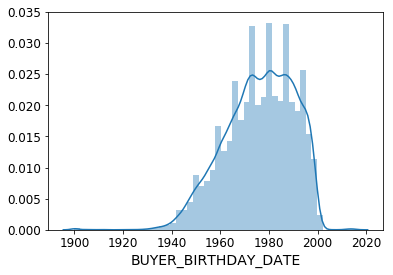

In [22]:
# Avant
sns.distplot(train_df.BUYER_BIRTHDAY_DATE.dropna(inplace=False));

In [23]:
mu, sigma = train_df.BUYER_BIRTHDAY_DATE.mean(), train_df.BUYER_BIRTHDAY_DATE.std() # mean et standard deviation
print("Mu = {} et sigma = {}".format(mu, sigma))

Mu = 1976.1299116435155 et sigma = 14.127001280909942


In [24]:
def normal_filler(value, mu, sigma, threshold):
    if np.isnan(value) or value<threshold:
        return np.random.normal(mu, sigma, 1)[0]
    else:
        return value;

In [25]:
train_df.BUYER_BIRTHDAY_DATE = train_df.BUYER_BIRTHDAY_DATE.apply(normal_filler, args=(mu,sigma,1930))
test_df.BUYER_BIRTHDAY_DATE = test_df.BUYER_BIRTHDAY_DATE.apply(normal_filler, args=(mu,sigma,1930))

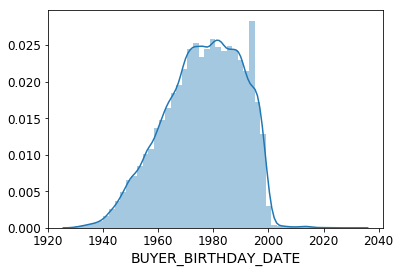

In [26]:
# Après
sns.distplot(train_df.BUYER_BIRTHDAY_DATE);

### BUYER_DEPARTMENT

On doit remplacer les valeurs:
    -1, 0, 96, 97, 98 qui n'existent pas

In [27]:
print("On a:\n{} valeurs à -1\n{} valeurs à 0\n{} valeurs à 96\n{} valeurs à 97\n{} valeurs à 98\n ".format(
train_df[train_df.BUYER_DEPARTMENT == -1].shape[0],
train_df[train_df.BUYER_DEPARTMENT == 0].shape[0],
train_df[train_df.BUYER_DEPARTMENT == 96].shape[0],
train_df[train_df.BUYER_DEPARTMENT == 97].shape[0],
train_df[train_df.BUYER_DEPARTMENT == 98].shape[0]))

On a:
231 valeurs à -1
24 valeurs à 0
454 valeurs à 96
1230 valeurs à 97
51 valeurs à 98
 


In [28]:
'''
Comme ca n'a pas de sens de remplir avec une loi normale
je propose de corriger tout ça en mettant tout à "0" pour montrer à l'algorithme le problème
''' 

def departement_filler(value):
    if value not in range(-1,96):
        return 0;
    else:
        return value;

train_df.BUYER_DEPARTMENT = train_df.BUYER_DEPARTMENT.apply(departement_filler)
test_df.BUYER_DEPARTMENT = test_df.BUYER_DEPARTMENT.apply(departement_filler)

### SELLER_DEPARTMENT

In [29]:
print("On a:\n{} valeurs à -1\n{} valeurs à 0\n{} valeurs à 96\n{} valeurs à 97\n{} valeurs à 98\n ".format(
            train_df[train_df.SELLER_DEPARTMENT == -1].shape[0],
            train_df[train_df.SELLER_DEPARTMENT == 0].shape[0],
            train_df[train_df.SELLER_DEPARTMENT == 96].shape[0],
            train_df[train_df.SELLER_DEPARTMENT == 97].shape[0],
            train_df[train_df.SELLER_DEPARTMENT == 98].shape[0]
        )
     )

On a:
42318 valeurs à -1
0 valeurs à 0
188 valeurs à 96
0 valeurs à 97
3 valeurs à 98
 


In [30]:
'''
42 318 valeurs à -1 parce qu'a l'étranger, ça me semble impossible à gérer de façon smart

On remplace tout les autres à zéro? Oui? Très bien
''' 

train_df.SELLER_DEPARTMENT = train_df.SELLER_DEPARTMENT.apply(departement_filler)
test_df.SELLER_DEPARTMENT = test_df.SELLER_DEPARTMENT.apply(departement_filler)

### PRODUCT_FAMILY

In [31]:
print("On a {} valeurs à WHITE".format(train_df[train_df.PRODUCT_FAMILY == 'WHITE'].shape[0]))

On a 8907 valeurs à WHITE


Un peu complexe là, on sait que WHITE contient une majorité de `PRODUCT_TYPE` "BRICOLAGE", donc bon, faudrait refaire un mapping dans la classe, mais j'ai la flemme

### Bilan des corrections d'erreurs et de données manquantes

Ben on est bien là! On a corrigé nos trucs, et tout le monde est content

In [32]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
SHIPPING_MODE           100000 non-null object
SHIPPING_PRICE          100000 non-null object
WARRANTIES_FLG          100000 non-null bool
WARRANTIES_PRICE        100000 non-null object
CARD_PAYMENT            100000 non-null int64
COUPON_PAYMENT          100000 non-null int64
RSP_PAYMENT             100000 non-null int64
WALLET_PAYMENT          100000 non-null int64
PRICECLUB_STATUS        100000 non-null object
REGISTRATION_DATE       100000 non-null int64
PURCHASE_COUNT          100000 non-null object
BUYER_BIRTHDAY_DATE     100000 non-null float64
BUYER_DEPARTMENT        100000 non-null int64
BUYING_DATE             100000 non-null object
SELLER_SCORE_COUNT      100000 non-null object
SELLER_SCORE_AVERAGE    100000 non-null float64
SELLER_COUNTRY          100000 non-null object
SELLER_DEPARTMENT       100000 non-null int64
PRODUCT_TYPE            100000 non-null object
PROD

## Traitement des variables

**Variables Mixtes**

C'est à dire qu'elles contiennes en fait de l'alphanumérique, et des structures à l'interieur

1. `SHIPPING_PRICE`         - Format Nombre </> Nombre
2. `WARRANTIES_PRICE`         - Format Nombre </> Nombre
3. `PURCHASE_COUNT`         - Format Nombre </> Nombre
4. `BUYING_DATE`         - Format Nombre/2017
5. `SELLER_SCORE_COUNT`         - Format Nombre </> Nombre
6. `ITEM_PRICE`         - Format Nombre </> Nombre

Bon, en y regardant de plus près:

On ne peut pas tirer de ces variables catégorielles des variables continues.

La seule information que nous avons c'est l'ordre de grandeur. Alors transformons les en variables __ordinales__

### SHIPPING_PRICE

In [33]:
# Exemple avant
print(train_df.SHIPPING_PRICE.sort_values().unique())
print(test_df.SHIPPING_PRICE.sort_values().unique())

['0' '10<20' '1<5' '5<10' '<1' '>20']
['0' '10<20' '1<5' '5<10' '<1' '>20']


In [34]:
mapper= {'0':0, '<1':1, '1<5':2, '5<10':3, '10<20':4, '>20':5}

train_df.SHIPPING_PRICE = train_df.SHIPPING_PRICE.map(mapper)
test_df.SHIPPING_PRICE = test_df.SHIPPING_PRICE.map(mapper)

In [35]:
# Et maintenant après transformation
print(train_df.SHIPPING_PRICE.sort_values().unique())
print(test_df.SHIPPING_PRICE.sort_values().unique())

[0 1 2 3 4 5]
[0 1 2 3 4 5]


### WARRANTIES_PRICE

In [36]:
print(train_df.WARRANTIES_PRICE.sort_values().unique())
print(test_df.WARRANTIES_PRICE.sort_values().unique())

['0' '100<500' '20<50' '50<100' '5<20' '<5']
['0' '100<500' '20<50' '50<100' '5<20' '<5']


In [37]:
mapper={'0':0, '<5':1, '5<20':2, '20<50':3, '50<100':4,  '100<500':5}

train_df.WARRANTIES_PRICE = train_df.WARRANTIES_PRICE.map(mapper)
test_df.WARRANTIES_PRICE = test_df.WARRANTIES_PRICE.map(mapper)

### PURCHASE_COUNT

In [38]:
print(train_df.PURCHASE_COUNT.sort_values().unique())
print(test_df.PURCHASE_COUNT.sort_values().unique())

['100<500' '20<50' '50<100' '5<20' '<5' '>500']
['100<500' '20<50' '50<100' '5<20' '<5' '>500']


In [39]:
mapper={'<5':0, '5<20':1, '20<50':2, '50<100':3, '100<500':4,  '>500':5}

train_df.PURCHASE_COUNT = train_df.PURCHASE_COUNT.map(mapper)
test_df.PURCHASE_COUNT = test_df.PURCHASE_COUNT.map(mapper)

### BUYING_DATE

In [40]:
print(train_df.BUYING_DATE.sort_values().unique())
print(test_df.BUYING_DATE.sort_values().unique())

['1/2017' '10/2017' '2/2017' '3/2017' '4/2017' '5/2017' '6/2017' '7/2017'
 '8/2017' '9/2017']
['1/2017' '10/2017' '2/2017' '3/2017' '4/2017' '5/2017' '6/2017' '7/2017'
 '8/2017' '9/2017']


In [41]:
toto= train_df.BUYING_DATE.str.split('/', 1, expand=True)
train_df.BUYING_DATE = toto[0]
train_df.BUYING_DATE = train_df.BUYING_DATE.apply(pd.to_numeric, errors='ignore')

toto= test_df.BUYING_DATE.str.split('/', 1, expand=True)
test_df.BUYING_DATE = toto[0]
test_df.BUYING_DATE = test_df.BUYING_DATE.apply(pd.to_numeric, errors='ignore')

del toto

### SELLER_SCORE_COUNT

In [42]:
print(train_df.SELLER_SCORE_COUNT.sort_values().unique())
print(test_df.SELLER_SCORE_COUNT.sort_values().unique())

['100000<1000000' '10000<100000' '1000<10000' '100<1000' '<100']
['100000<1000000' '10000<100000' '1000<10000' '100<1000' '<100']


In [43]:
mapper={'<100':0, '100<1000':1, '1000<10000':2, '10000<100000':3, '100000<1000000':4}

train_df.SELLER_SCORE_COUNT = train_df.SELLER_SCORE_COUNT.map(mapper)
test_df.SELLER_SCORE_COUNT = test_df.SELLER_SCORE_COUNT.map(mapper)

### ITEM_PRICE

In [44]:
print(train_df.ITEM_PRICE.sort_values().unique())
print(test_df.ITEM_PRICE.sort_values().unique())

['1000<5000' '100<500' '10<20' '20<50' '500<1000' '50<100' '<10' '>5000']
['1000<5000' '100<500' '10<20' '20<50' '500<1000' '50<100' '<10']


In [45]:
mapper={'<10':0, '10<20':1, '20<50':2, '50<100':3, '100<500':4,  '500<1000':5, '1000<5000':6, '>5000':6} #Il existe qu'un >5000, et il n'existe pas dans le jeu de test

train_df.ITEM_PRICE = train_df.ITEM_PRICE.map(mapper)
test_df.ITEM_PRICE = test_df.ITEM_PRICE.map(mapper)

In [46]:
del mapper

### PRICECLUB_STATUS

In [47]:
print(train_df.PRICECLUB_STATUS.sort_values().unique())
print(test_df.PRICECLUB_STATUS.sort_values().unique())

['GOLD' 'PLATINUM' 'REGULAR' 'SILVER' 'UNSUBSCRIBED']
['GOLD' 'PLATINUM' 'REGULAR' 'SILVER' 'UNSUBSCRIBED']


Le classement des types de comptes est inscrit ici : https://www.priceminister.com/evt/rakuten-superpoints

En faisant ça, je veux garder l'information "classement"

In [48]:
mapper={'UNSUBSCRIBED':0, 'REGULAR':1, 'SILVER':2, 'GOLD':3, 'PLATINUM':4}

train_df.PRICECLUB_STATUS = train_df.PRICECLUB_STATUS.map(mapper)
test_df.PRICECLUB_STATUS = test_df.PRICECLUB_STATUS.map(mapper)

## Drop Duplicates


Finding duplicates in your data is important because you end up:

1. Spending more computational time to process duplicates, which slows your algorithms down.

2. Obtaining false results because duplicates implicitly overweight the results. 

Because some entries appear more than once, the algorithm considers these entries more important.

Ok, mais ici, on a aucun duplicate dans la classe majoritaire, donc je préfère ne rien droper finalement

In [49]:
train_df.shape

(100000, 22)

In [50]:
train_df.drop_duplicates(inplace=False).shape

(96851, 22)

Mais si on enlève les duplicates on perd 3149 lignes... Donc c'est mort de mon point de vue

### Bilan

Ben on est bien là! On a transformé tout ça en variables __ordinales__, et tout le monde est content

In [51]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
SHIPPING_MODE           100000 non-null object
SHIPPING_PRICE          100000 non-null int64
WARRANTIES_FLG          100000 non-null bool
WARRANTIES_PRICE        100000 non-null int64
CARD_PAYMENT            100000 non-null int64
COUPON_PAYMENT          100000 non-null int64
RSP_PAYMENT             100000 non-null int64
WALLET_PAYMENT          100000 non-null int64
PRICECLUB_STATUS        100000 non-null int64
REGISTRATION_DATE       100000 non-null int64
PURCHASE_COUNT          100000 non-null int64
BUYER_BIRTHDAY_DATE     100000 non-null float64
BUYER_DEPARTMENT        100000 non-null int64
BUYING_DATE             100000 non-null int64
SELLER_SCORE_COUNT      100000 non-null int64
SELLER_SCORE_AVERAGE    100000 non-null float64
SELLER_COUNTRY          100000 non-null object
SELLER_DEPARTMENT       100000 non-null int64
PRODUCT_TYPE            100000 non-null object
PRODUCT_FA

Actuellement, il nous reste quatre variables catégorielles:
1. `SHIPPING_MODE`
2. `SELLER_COUNTRY`
3. `PRODUCT_TYPE`
4. `PRODUCT_FAMILY`

Il n'y a pas de classement à faire entre ces catégories, on verra ça dans le Notebook 2 Feature Engineering.

Mais quel teasing!

Et on oublie pas d'écrire les résultats de nos transformations.

In [52]:
filename_train = DATA_PROCESSED+"/train_notebook_1.csv"
filename_test = DATA_PROCESSED+"/test_notebook_1.csv"

try:
    os.remove(filename_train)
    os.remove(filename_test)
except:
    pass;
    
train_df.to_csv(filename_train, index=False, sep=";")
test_df.to_csv(filename_test, index=False, sep=";")